In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 
import scipy.stats as stats
from stargazer.stargazer import Stargazer, LineLocation
import nltk
from nltk.corpus import stopwords
import lemmy

In [2]:
dataset = pd.read_csv("cleandata.csv",index_col="Unnamed: 0")


In [3]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-08-26", "%Y-%m-%d")

In [4]:
dataset['datetime'] = [datetime.strptime(d, "%Y-%m-%d") for d in dataset['datetime']]
dataset['date_clean'] = [datetime.strptime(str(d), "%Y-%m-%d") for d in dataset['date_clean']]
dataset = dataset[dataset['datetime'] > dstart]

In [5]:
dataset = dataset.reset_index(drop = True)

In [6]:
plt.rcParams.update({'font.size': 22})

In [7]:
dataset.columns

Index(['post_nr', 'date', 'text', 'likes', 'user', 'date_clean', 'datetime',
       'days_till_linde', 'days_till_linde_28', 'path', 'n_people', 'n_women',
       'n_men', 'share_women', 'share_women_no_none', 'treatment',
       'treatment_28', 'name', 'sex', 'party', 'bloc', 'week', 'monthyear',
       'superuser', 'tenpercent', 'percentile', 'women_binary', 'men_binary'],
      dtype='object')

In [8]:
dataset['days_till_linde_norm'] = [dataset['days_till_linde'] + abs(dataset['days_till_linde'].min())][0]

## Full period

In [9]:
def ttest_date(dataset, cutoff = datetime.strptime("2020-08-26", "%Y-%m-%d"),metric = "share_women"):
    before =dataset['datetime'] < cutoff
    after = dataset['datetime'] >= cutoff
    
    mean_before =  np.mean(dataset.loc[before,metric])
    mean_after =  np.mean(dataset.loc[after,metric])
    
    print("Mean", metric,"in posts in posts before:", mean_before)
    print("Mean", metric,"in posts in posts after:", mean_after)

    t, p = stats.ttest_ind(dataset.loc[before,metric],dataset.loc[after,metric] , equal_var=False)
    
    print("the t-value is:",t,"\n the p-value is:",p)
    print("the difference in mean is: ",round(mean_after-mean_before,3),"\n It is a change of", round(mean_after-mean_before,5) * 100,"percentage points more/less women")

In [10]:
ttest_date(dataset, metric = "women_binary")

Mean women_binary in posts in posts before: 0.33843706502286736
Mean women_binary in posts in posts after: 0.4013365509560052
the t-value is: -6.662117397455466 
 the p-value is: 2.8355530731190055e-11
the difference in mean is:  0.063 
 It is a change of 6.29 percentage points more/less women


In [11]:
ks, p = stats.ks_2samp(dataset[dataset['treatment'] == 0]['women_binary'],dataset[dataset['treatment'] == 1]['women_binary'])

In [12]:
print("P-value for samlple equality test:",p)

P-value for samlple equality test: 2.153632272516859e-09


In [20]:
mean_women_set = dataset.groupby('date_clean').agg({'women_binary': ['mean','sum']})
mean_women_set = mean_women_set['women_binary'] 
dates = mean_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
mean_women_set['dates'] = dates
mean_women_set = mean_women_set.reset_index(drop = True)

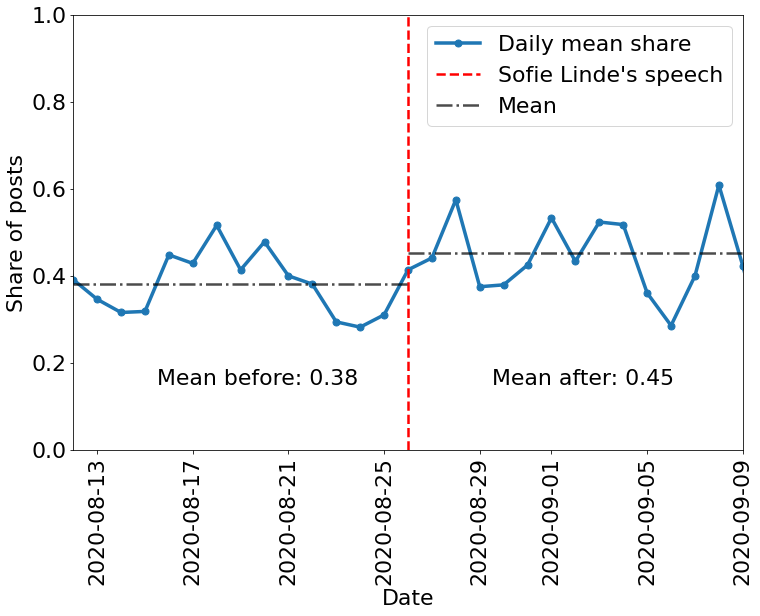

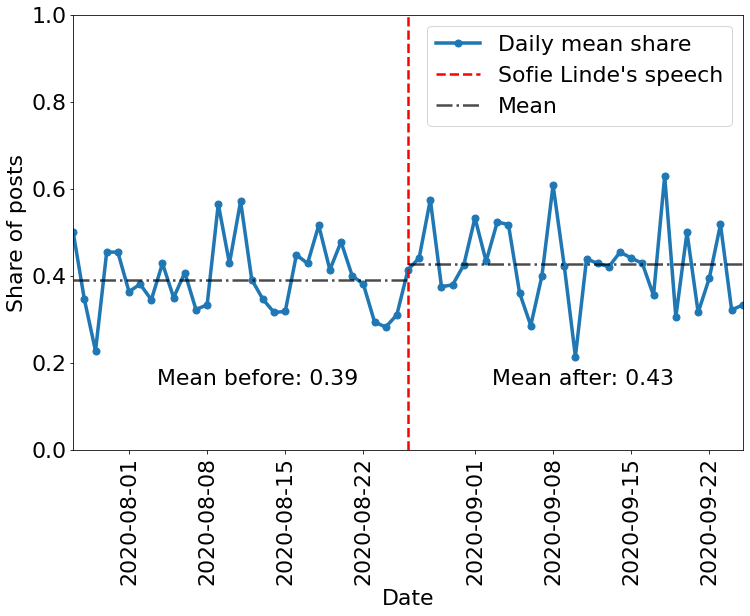

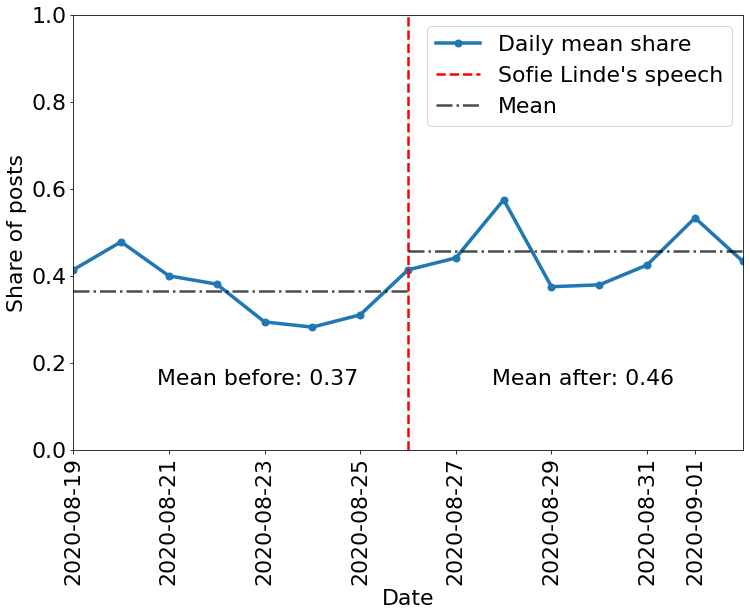

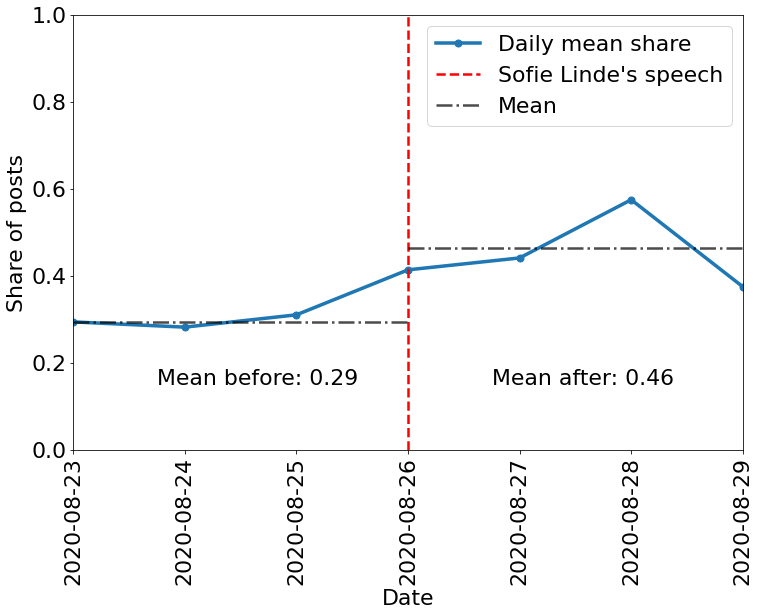

In [27]:
for i in [14,30,7,3]:
    thirty_days = dataset[abs(dataset['days_till_linde']) <=i]
    before = thirty_days.loc[thirty_days['treatment'] == 0,'women_binary'].mean()
    after = thirty_days.loc[thirty_days['treatment'] == 1,'women_binary'].mean()
    dateend = linde_date + timedelta(i)
    dstart = linde_date - timedelta(i)

    #n_women_set.plot(y = "mean",x = "dates", label = "Daily mean amount")
    plt.figure(figsize=(12,8))
    plt.plot(mean_women_set['dates'],mean_women_set['mean'], label = "Daily mean share", marker= ".", markersize=14, linewidth=3.5)
    #plt.plot()
    plt.xlim(dstart,dateend)
    plt.ylim(0,1.5)
    plt.xticks(rotation = 90)
    #plt.title("Daily mean amount of women in images")
    plt.axvline(x = linde_date, color = 'r', label = 'Sofie Linde\'s speech', linestyle = "--", linewidth=2.5) 
    plt.axhline(before, xmax = 0.5, color = 'black', label = 'Mean', linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.axhline(after, xmin = 0.5, color = 'black',  linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.annotate(str("Mean before: " + str(round(before,2))), xy =  (dstart + timedelta(i/4),0.15))
    plt.annotate(str("Mean after: " + str(round(after,2))), xy =  (dateend - timedelta((i/4)*3),0.15))

    plt.xlim(linde_date - timedelta(i),linde_date + timedelta(i))
    plt.ylim(0,1)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Share of posts")
    name = "plots\\daily_share_" +"binary_" +  str(i) +".png"
    plt.savefig(name,bbox_inches = "tight")
    plt.show()

# model for assignment

In [13]:
y = "women_binary"

In [14]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset).fit() 
model2 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=30]).fit() 
model3 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=14]).fit() 
model4 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=7]).fit() 
model5 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=3]).fit() 


stargazer = Stargazer([model1,model2,model3,model4,model5])
stargazer.title('Baseline models')
stargazer

Optimization terminated successfully.
         Current function value: 0.657348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656619
         Iterations 5


In [15]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0629      0.009      6.663      0.000       0.044       0.081
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0384      0.023      1.665      0.096      -0.007       0.084
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025    

## Sex and block

In [31]:
day = 14

In [32]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model1,model2,model3,model4,model5,model6])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.677783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677322
         Iterations 4


In [30]:
model7 = sm.logit(formula= y + " ~ treatment + days_till_linde" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ treatment* days_till_linde" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model7,model8])
stargazer.title('Heterogenous effectss')
stargazer


Optimization terminated successfully.
         Current function value: 0.656389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656388
         Iterations 5


In [19]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model6.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0721      0.032      2.260      0.024       0.010       0.135
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex[T.m]      -0.2504      0.031     -8.167      0.000      -0.310      -0.190
treatment      0.0593      0.031      1.914      0.056      -0.001       0.120
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

### examening 3,7 and 30 days sex and block

In [20]:
day = 3

In [21]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model7 = sm.logit(formula= y + " ~ bloc + days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ bloc * days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model1,model2,model3,model4,model5,model6,model7,model8])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.656619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655557
         Iterations 5


In [22]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model6.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.1704      0.066      2.569      0.010       0.040       0.300
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex[T.m]      -0.2183      0.066     -3.298      0.001      -0.348      -0.089
treatment      0.1300      0.067      1.936      0.053      -0.002       0.262
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

In [23]:
day = 7

In [24]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model7 = sm.logit(formula= y + " ~ bloc + days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ bloc * days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model1,model2,model3,model4,model5,model6,model7,model8])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.674731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676222
         Iterations 4


In [25]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model6.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0923      0.044      2.076      0.038       0.005       0.179
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex[T.m]      -0.2461      0.043     -5.746      0.000      -0.330      -0.162
treatment      0.0815      0.043      1.885      0.059      -0.003       0.166
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

In [26]:
day = 30

In [27]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model7 = sm.logit(formula= y + " ~ bloc + days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ bloc * days_till_linde_norm" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model1,model2,model3,model4,model5,model6,model7,model8])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.676592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677119
         Iterations 4


In [28]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model6.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0384      0.023      1.665      0.096      -0.007       0.084
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex[T.m]      -0.2789      0.022    -12.756      0.000      -0.322      -0.236
treatment      0.0283      0.022      1.274      0.203      -0.015       0.072
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

## looking at regression for super users and top 10 percenet

In [29]:
day = 14

In [30]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3, model4, model5])
stargazer.title('Heterogenous effects superuser')
stargazer

Optimization terminated successfully.
         Current function value: 0.677783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676815
         Iterations 4


In [31]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())


        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0721      0.032      2.260      0.024       0.010       0.135
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
superuser     -0.0327      0.041     -0.788      0.431      -0.114       0.049
treatment      0.0711      0.032      2.228      0.026       0.009       0.134
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

In [32]:
day = 3

In [33]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3, model4, model5])
stargazer.title('Heterogenous effects superuser')
stargazer

Optimization terminated successfully.
         Current function value: 0.656619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653246
         Iterations 5


In [34]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.1704      0.066      2.569      0.010       0.040       0.300
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
superuser     -0.1070      0.085     -1.256      0.209      -0.274       0.060
treatment      0.1777      0.066      2.688      0.007       0.048       0.307
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

In [35]:
day = 7

In [36]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3, model4, model5])
stargazer.title('Heterogenous effects superuser')
stargazer

Optimization terminated successfully.
         Current function value: 0.674731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671477
         Iterations 5


In [37]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0923      0.044      2.076      0.038       0.005       0.179
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
superuser     -0.0468      0.059     -0.799      0.424      -0.162       0.068
treatment      0.0925      0.044      2.083      0.037       0.005       0.180
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

In [38]:
day = 30

In [39]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3, model4, model5])
stargazer.title('Heterogenous effects superuser')
stargazer

Optimization terminated successfully.
         Current function value: 0.676592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675251
         Iterations 4


In [40]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0384      0.023      1.665      0.096      -0.007       0.084
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
superuser     -0.0283      0.029     -0.977      0.329      -0.085       0.029
treatment      0.0379      0.023      1.639      0.101      -0.007       0.083
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                          

# Analysis of linear and curvelinear decay 

In [41]:
dataset['days_till_linde_decay'] = 0                 

In [45]:
dataset['days_till_linde_decay'] = dataset.loc[dataset['treatment'] == 1, 'days_till_linde']

In [51]:
dataset.loc[dataset['treatment'] == 0,'days_till_linde_decay'] = 0

In [64]:
day = 3

In [65]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ days_till_linde_decay +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model3 = sm.logit(formula= y + " ~ days_till_linde_decay * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ days_till_linde_decay + np.power(days_till_linde_decay,2) + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ days_till_linde_decay + np.power(days_till_linde_decay,2) + np.power(days_till_linde_decay,3) + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2, model4, model5])
stargazer.title('Heterogenous effects superuser')
stargazer

Optimization terminated successfully.
         Current function value: 0.656619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649263
         Iterations 5
